# Binary Urban Model Tuning and Implementation

Similar to the Binary Ural Model Turning and Implementation process, this notebook demonstrates the process of fine-tuning and implementing the best algorithm identified for binary class modeling (XGB) for the urban area.

<a id='sections'></a>
**Sections**
- [**5.Binary Urban Model Tuning and Implementation**](#binary-urban-model-tuning-and-implementation)
    - [Examine the Distribution of Training Data](#examine-the-distribution-of-training-data)
    - [Comparing Machine Learning Algorithms](#comparing-machine-learning-algorithms)
        - Logistic Regression
        - Support Vector Machine
        - Random Forest
        - XGBoost
        - Conclusion
    - [Discovering the Best Model with the Selected Algorithm (XGBoost)](#discovering-the-best-model-with-the-selected-algorithm)
    - [Resampling](#resampling)
    - [Final Model](#final-model)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import pickle
from numpy import argmax
import importlib
import collections
import time
import getpass
import datetime as datetime
from shapely import wkt
from matplotlib import pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer,  LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, brier_score_loss, auc
from sklearn.metrics import f1_score, fbeta_score, confusion_matrix, make_scorer, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import  StratifiedKFold, KFold, cross_val_score, StratifiedShuffleSplit
from sklearn.model_selection import  RepeatedStratifiedKFold, GridSearchCV, cross_validate

from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from varname import nameof

In [2]:
# import modules
import sys; sys.path.insert(0, '../..')
from src import models
from src.models import *
# importlib.reload (src.models)
from src.data_preprocessing import geo_segmentid

Using TensorFlow backend.


In [3]:
base_gis_dir  = "G:/CUUATS/Safety Forecasting Tool/"
base_file_dir = "L:/Safety Forecasting Tool/"
base_tool_dir = "L:/Safety_Crash Data Analysis/"

In [4]:
with open(base_file_dir+'data/processed/df_urban_train_2014_2017.pkl', 'rb') as f:
    df_urban_train = pickle.load(f)
with open(base_file_dir+'data/processed/df_urban_train_label_2014_2017.pkl', 'rb') as f:
    df_urban_train_label = pickle.load(f)
with open(base_file_dir+'data/processed/df_urban_test_2018.pkl', 'rb') as f:
    df_urban_test = pickle.load(f)
with open(base_file_dir+'data/processed/df_urban_test_label_2018.pkl', 'rb') as f:
    df_urban_test_label = pickle.load(f)

In [5]:
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
def precision(y_true, y_pred): return precision_score(y_true, y_pred)
def recall(y_true, y_pred): return recall_score(y_true, y_pred)
def fbeta_2(y_true,y_pred,beta=2.0): return fbeta_score(y_true, y_pred, beta=2.0)

scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn), 'fp': make_scorer(fp), 'fn': make_scorer(fn),
           'precision':make_scorer(precision),'recall':make_scorer(recall),
           'fbeta_2':make_scorer(fbeta_2)}

In [6]:
# Remove features that should not be fed into the model
remove_list=['segment_id','overlap','geometry','Year']
targetlist = [i for i in list(df_urban_train.columns) if i not in remove_list]
df_urban_train_sub = df_urban_train[targetlist]
df_urban_test_sub = df_urban_test[targetlist]

In [7]:
# Convert full training & testing data to binary class categories
df_urban_train_bi_label = df_urban_train_label.mask(df_urban_train_label >=2, 1)
df_urban_test_bi_label=df_urban_test_label.mask(df_urban_test_label >= 2, 1)

In [8]:
X_train=df_urban_train_sub
y_train=df_urban_train_bi_label
X_test=df_urban_test_sub
y_test=df_urban_test_bi_label

X_train_OHtransformed=func_OHtransform_var(X_train)
OHfname = func_OHtransformed_var(X_train)
X_test_OHtransformed=func_OHtransform_var(X_test)

# Examining the Distribution of Training Data
<a id='examing-the-distribution-of-training-data'></a>
[[back to top](#sections)]

The distribution of the input data (training data) is examined at the very first step.

In [9]:
# Number of positive samples and negtive samples
pos_neg_counts = df_urban_train_sub.copy()
pos_neg_counts['y'] = df_urban_train_bi_label
pos_neg_counts.groupby(['functional_classification','y']).size()

functional_classification  y  
Interstate                 0.0      150
                           1.0      278
Local Road or Street       0.0    18145
                           1.0     1583
Major Arterial             0.0      421
                           1.0      591
Major Collector            0.0     1286
                           1.0      534
Minor Arterial             0.0     1187
                           1.0     1049
Minor Collector            0.0      280
                           1.0       56
dtype: int64

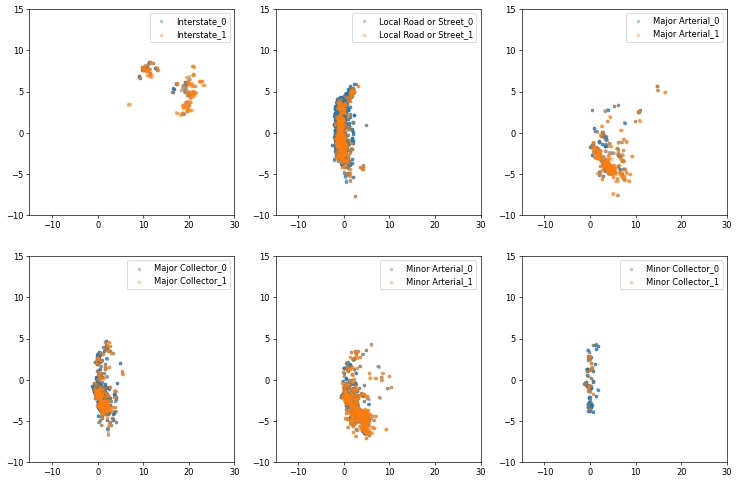

In [10]:
# Distribution of each roadway functional class in linear reduced dimension
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_OHtransformed_pca = pca.fit_transform(X_train_OHtransformed.toarray())
place_dict = dict({'Interstate':(0,0), 'Local Road or Street':(0,1), 'Major Arterial':(0,2),
                   'Major Collector':(1,0), 'Minor Arterial':(1,1), 'Minor Collector':(1,2)})
fig,ax=plt.subplots(2,3,figsize=(15,10),dpi=60)
for i,rdclass in enumerate(['Interstate', 'Local Road or Street', 'Major Arterial','Major Collector', 'Minor Arterial', 'Minor Collector']):
    df_X = X_train_OHtransformed_pca[df_urban_train_sub['functional_classification']==rdclass]
    df_y = df_urban_train_bi_label[df_urban_train_sub['functional_classification']==rdclass]
    ax[place_dict[rdclass]].scatter(df_X[df_y==0][:,0],df_X[df_y==0][:,1],label=rdclass+'_0',s=10,alpha=0.3)
    ax[place_dict[rdclass]].scatter(df_X[df_y==1][:,0],df_X[df_y==1][:,1],label=rdclass+'_1',s=10,alpha=0.3)
    ax[place_dict[rdclass]].set_xlim((-15,30))
    ax[place_dict[rdclass]].set_ylim((-10,15))
    ax[place_dict[rdclass]].legend()

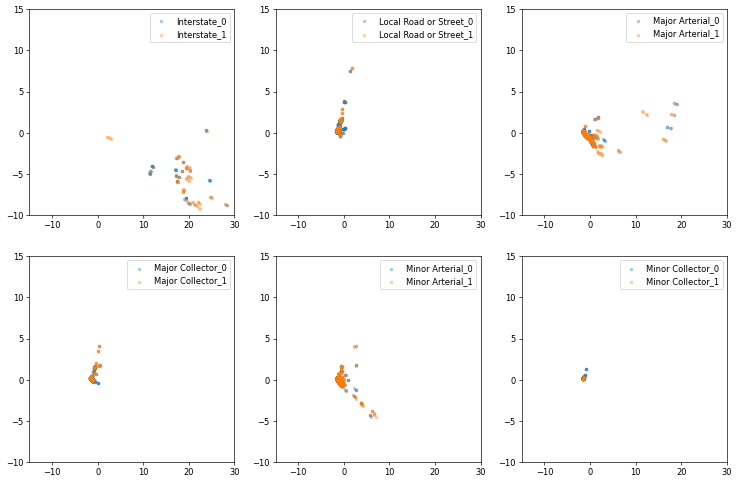

In [11]:
# Distribution of each roadway functional class in non-linear reduced dimension
from sklearn.decomposition import KernelPCA
pca = KernelPCA(n_components=2, kernel='poly',  gamma=0.05)
X_train_OHtransformed_pca = pca.fit_transform(X_train_OHtransformed.toarray())
place_dict = dict({'Interstate':(0,0), 'Local Road or Street':(0,1), 'Major Arterial':(0,2),
                   'Major Collector':(1,0), 'Minor Arterial':(1,1), 'Minor Collector':(1,2)})
fig,ax=plt.subplots(2,3,figsize=(15,10),dpi=60)
for i,rdclass in enumerate(['Interstate', 'Local Road or Street', 'Major Arterial','Major Collector', 'Minor Arterial', 'Minor Collector']):
    df_X = X_train_OHtransformed_pca[df_urban_train_sub['functional_classification']==rdclass]
    df_y = df_urban_train_bi_label[df_urban_train_sub['functional_classification']==rdclass]
    ax[place_dict[rdclass]].scatter(df_X[df_y==0][:,0],df_X[df_y==0][:,1],label=rdclass+'_0',s=10,alpha=0.3)
    ax[place_dict[rdclass]].scatter(df_X[df_y==1][:,0],df_X[df_y==1][:,1],label=rdclass+'_1',s=10,alpha=0.3)
    ax[place_dict[rdclass]].set_xlim((-15,30))
    ax[place_dict[rdclass]].set_ylim((-10,15))
    ax[place_dict[rdclass]].legend()

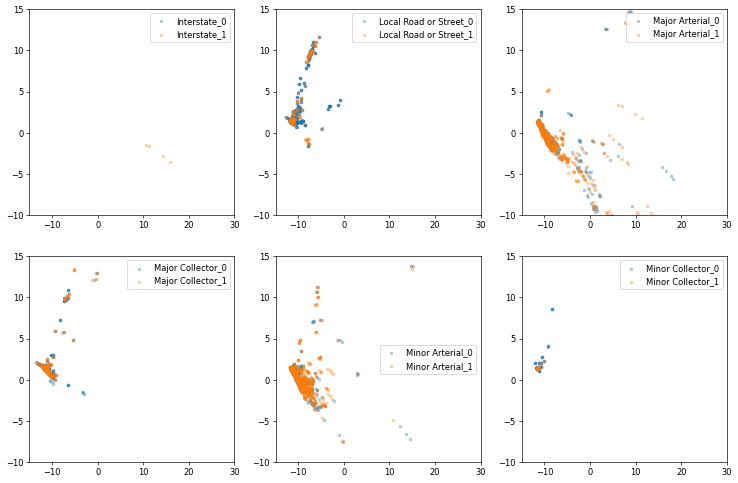

In [14]:
# Distribution of each roadway functional class in non-linear reduced dimension
from sklearn.decomposition import KernelPCA
pca = KernelPCA(n_components=2, kernel='poly',  gamma=0.2)
X_train_OHtransformed_pca = pca.fit_transform(X_train_OHtransformed.toarray())
place_dict = dict({'Interstate':(0,0), 'Local Road or Street':(0,1), 'Major Arterial':(0,2),
                   'Major Collector':(1,0), 'Minor Arterial':(1,1), 'Minor Collector':(1,2)})
fig,ax=plt.subplots(2,3,figsize=(15,10),dpi=60)
for i,rdclass in enumerate(['Interstate', 'Local Road or Street', 'Major Arterial','Major Collector', 'Minor Arterial', 'Minor Collector']):
    df_X = X_train_OHtransformed_pca[df_urban_train_sub['functional_classification']==rdclass]
    df_y = df_urban_train_bi_label[df_urban_train_sub['functional_classification']==rdclass]
    ax[place_dict[rdclass]].scatter(df_X[df_y==0][:,0],df_X[df_y==0][:,1],label=rdclass+'_0',s=10,alpha=0.3)
    ax[place_dict[rdclass]].scatter(df_X[df_y==1][:,0],df_X[df_y==1][:,1],label=rdclass+'_1',s=10,alpha=0.3)
    ax[place_dict[rdclass]].set_xlim((-15,30))
    ax[place_dict[rdclass]].set_ylim((-10,15))
    ax[place_dict[rdclass]].legend()

**Findings:**
- The dataset is very imbalanced between positive and negative classes.
- The charts above show that separating the positive class and negative by functional class using either linear or non-linear (polynomial) dimension reduction is challenging, with much overlap between the positive and negative class spaces observed under both principle component analysis method.

# Comparing Machine Learning Algorithms 
<a id='comparing-machine-learning-algorithm'></a>
[[back to top](#sections)]

- 4 machine learning algorithms are tested in this study 
    - (i) Logistic regression 
    - (ii) Support Vector Machine (SVC)
    - (iii) Random Forest 
    - (iv) eXtreme Gradient Boosting (XGBoost)
- The hyperparameter tuning process of SVC,Random Forest, and XGBoost are conducted on AWS EC2. 
- The model performance evaluation is based on the f2 score.

## Logistic regression

In [11]:
from sklearn.linear_model import LogisticRegression

Time needed for training the model:  2.76 seconds
No Skill Model PR AUC: 0.220
Model PR AUC: 0.591
From Training data:
Best Threshold=0.112230, precision=0.374, recall=0.799, F2_Score=0.651


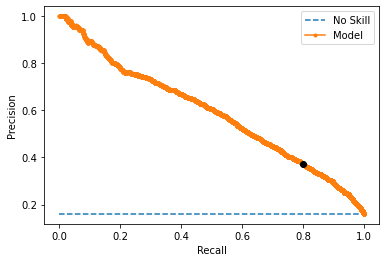

Results of testing data:
          pred_neg  pred_pos
true_neg      4000      1331
true_pos       210       849


In [12]:
sampling=None
LRmodel=LogisticRegression(solver='lbfgs', max_iter=1000)
t0 = time.time()
LRmodel_fitted=LRmodel.fit(X_train_OHtransformed, y_train)
t1 = time.time()
print('Time needed for training the model: ',round(t1-t0,2),'seconds')
model_results= binary_summary_report (X_train_OHtransformed, y_train, X_test_OHtransformed, y_test, LRmodel_fitted)

Interstate
          pred_neg  pred_pos
true_neg         2        29
true_pos         2        74
Local Road or Street
          pred_neg  pred_pos
true_neg      3881       657
true_pos       194       200
Major Arterial
          pred_neg  pred_pos
true_neg         1        97
true_pos         0       155
Major Collector
          pred_neg  pred_pos
true_neg        68       238
true_pos        11       138
Minor Arterial
          pred_neg  pred_pos
true_neg        18       264
true_pos         2       275
Minor Collector
          pred_neg  pred_pos
true_neg        30        46
true_pos         1         7
Overall
          pred_neg  pred_pos
true_neg      4000      1331
true_pos       210       849
F2score: 0.66 Precision: 0.39 Recall: 0.8 Fpr: 0.25


f2score precision recall   fpr
Interstate              0.91      0.72   0.97  0.94
Local Road or Street    0.41      0.23   0.51  0.14
Major Arterial          0.89      0.62    1.0  0.99
Major Collector         0.71      0.37   0.93  0.78
Minor Arterial          0.83      0.51   0.99  0.94
Minor Collector         0.41      0.13   0.88  0.61
Overall                 0.66      0.39    0.8  0.25

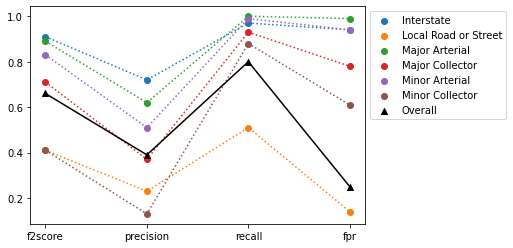

In [13]:
best_thres = model_results[1]
y_test_pred = LRmodel_fitted.predict_proba(X_test_OHtransformed)[:,1]
y_test_pred_adj = [1 if y>=best_thres else 0 for y in y_test_pred]
cfm_fc_df = cfm_fc(X_test, y_test, y_test_pred_adj)
cfm_fc_df

## Support Vector Machine

In [14]:
from sklearn.svm import SVC

Hyperparamater tuning range:
- kernel: ['linear', 'poly','rbf']
- class_weight: [{1:1},{1:2},{1:3}]

In [15]:
# SVC model tuning enabled by AWS_EC2_BinaryUrban_SVC.py
with open(base_file_dir+'data/AWS Tuning results/BinaryUrban_SVC_search_results_old.pkl', 'rb') as f:
    BinaryUrban_SVC_search_results = pickle.load(f)

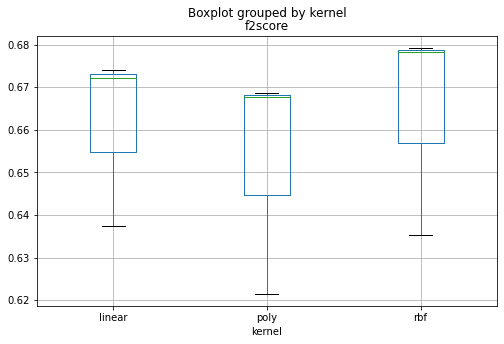

In [16]:
# An overview of the results of the model tuning executed on AWS EC2
BinaryUrban_SVC_search_results.boxplot(column=['f2score'],by='kernel',figsize=(8,5))

In [17]:
# An overview of the results of the model tuning executed on AWS EC2
BinaryUrban_SVC_search_results.sort_values(by='f2score',ascending=False).head(5)

kernel class_weight  threshold  precision    recall   f1score   f2score  \
7     rbf       {1: 2}   0.082669   0.434579  0.790368  0.560804  0.679163   
8     rbf       {1: 3}   0.079350   0.435122  0.788480  0.560779  0.678310   
2  linear       {1: 3}   0.079234   0.374633  0.842304  0.518605  0.674021   
1  linear       {1: 2}   0.088327   0.392744  0.817753  0.530637  0.672256   
4    poly       {1: 2}   0.088444   0.411476  0.792257  0.541640  0.668526   

         time  
7  416.971811  
8  469.778446  
2  758.856494  
1  675.730529  
4  384.976301

It can be observed from the boxplot and the table that:
- (1) For this study, 'rbf' kernel is better than the linear kernel and the poly kernel.
- (2) The best model found by SVC has a close performance to the Logistic Regression model. However, It requires much more time to train a SVC model than the Logistic Regression model.

Time needed for training the model:  309.13 seconds
No Skill Model PR AUC: 0.243
Model PR AUC: 0.662
From Training data:
Best Threshold=0.082411, precision=0.434, recall=0.832, F2_Score=0.703


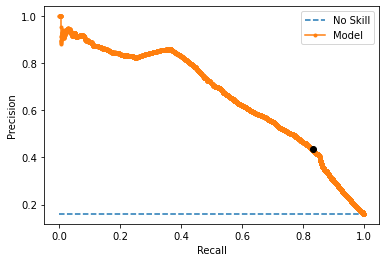

Results of testing data:
          pred_neg  pred_pos
true_neg      4170      1161
true_pos       214       845


In [18]:
sampling=None
Bestparam = zip(list(BinaryUrban_SVC_search_results.sort_values(by=['f2score'],ascending=False).head(1).columns), 
              BinaryUrban_SVC_search_results.sort_values(by=['f2score'],ascending=False).head(1).values.tolist()[0])
BestparamDict = dict(Bestparam)
SVCmodel=SVC(random_state = 42,probability=True,
            kernel=BestparamDict['kernel'],class_weight=BestparamDict['class_weight'])
t0 = time.time()
SVCmodel_fitted=SVCmodel.fit(X_train_OHtransformed, y_train)
t1 = time.time()
print('Time needed for training the model: ',round(t1-t0,2),'seconds')
model_results = binary_summary_report (X_train_OHtransformed, y_train, X_test_OHtransformed, y_test, SVCmodel_fitted)

Interstate
          pred_neg  pred_pos
true_neg         2        29
true_pos         1        75
Local Road or Street
          pred_neg  pred_pos
true_neg      3952       586
true_pos       192       202
Major Arterial
          pred_neg  pred_pos
true_neg         4        94
true_pos         0       155
Major Collector
          pred_neg  pred_pos
true_neg       129       177
true_pos        14       135
Minor Arterial
          pred_neg  pred_pos
true_neg        33       249
true_pos         5       272
Minor Collector
          pred_neg  pred_pos
true_neg        50        26
true_pos         2         6
Overall
          pred_neg  pred_pos
true_neg      4170      1161
true_pos       214       845
F2score: 0.68 Precision: 0.42 Recall: 0.8 Fpr: 0.22


f2score precision recall   fpr
Interstate              0.92      0.72   0.99  0.94
Local Road or Street    0.43      0.26   0.51  0.13
Major Arterial          0.89      0.62    1.0  0.96
Major Collector         0.74      0.43   0.91  0.58
Minor Arterial          0.83      0.52   0.98  0.88
Minor Collector         0.47      0.19   0.75  0.34
Overall                 0.68      0.42    0.8  0.22

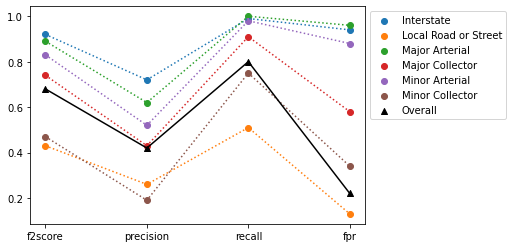

In [19]:
best_thres = model_results[1]
y_test_pred = SVCmodel_fitted.predict_proba(X_test_OHtransformed)[:,1]
y_test_pred_adj = [1 if y>=best_thres else 0 for y in y_test_pred]
cfm_fc_df = cfm_fc(X_test, y_test, y_test_pred_adj)
cfm_fc_df

## Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

Hyperparamater tuning range:
- n_estimators: [5,10,25,50,100,200, 300, 500, 1000, 1500, 2000,3000,4000,5000]
- max_depth: [3,4,5,6,7,8]
- max_features: [3,4,5,6,7,8]
- min_samples_split: [0.2,0.4,0.6,0.8,0.9]

In [21]:
# Random Forest model tuning enabled by AWS_EC2_BinaryUrban_RF.py
with open(base_file_dir+'data/AWS Tuning results/BinaryUrban_RF_search_results.pkl', 'rb') as f:
    BinaryUrban_RF_search_results = pickle.load(f)

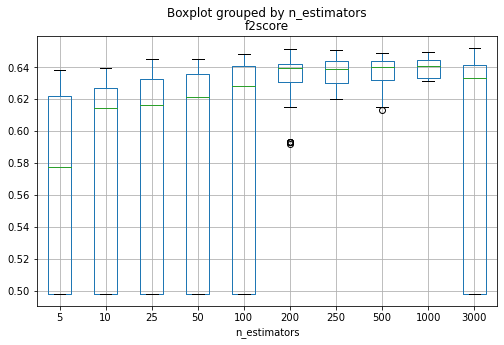

In [22]:
# An overview of the results of the model tuning executed on AWS EC2
BinaryUrban_RF_search_results[BinaryUrban_RF_search_results['f2score']>0.1].boxplot(column=['f2score'],by='n_estimators',figsize=(8,5))

In [23]:
BinaryUrban_RF_search_results.sort_values(by=['f2score'],ascending=False).head(5)

n_estimators  max_depth  max_features  min_samples_split  threshold  \
1445          3000          6             7                0.2       0.13   
886            200          8             5                0.4       0.13   
861            200          7             5                0.4       0.13   
1035           250          8             5                0.2       0.13   
1470          3000          7             7                0.2       0.13   

      precision    recall   f1score   f2score       fpr    tn    fp   fn   tp  \
1445   0.360868  0.816808  0.500579  0.652043  0.287376  3799  1532  194  865   
886    0.359817  0.816808  0.499567  0.651355  0.288689  3792  1539  194  865   
861    0.360150  0.815864  0.499711  0.651093  0.287938  3796  1535  195  864   
1035   0.355392  0.821530  0.496151  0.650808  0.296005  3753  1578  189  870   
1470   0.355419  0.820585  0.496005  0.650352  0.295629  3755  1576  190  869   

           time  
1445  11.678412  
886    0.885281  
861    0.862639  
1035   1.106352  
1470  11.823304

n_estimators= 3000 max_depth= 6 max_features= 7 min_samples_split= 0.2
Time needed for training the model:  7.15 seconds
No Skill Model PR AUC: 0.222
Model PR AUC: 0.502
From Training data:
Best Threshold=0.127000, precision=0.340, recall=0.814, F2_Score=0.637


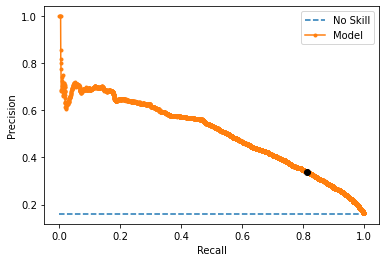

Results of testing data:
          pred_neg  pred_pos
true_neg      3749      1582
true_pos       189       870


In [24]:
sampling=None
Bestparam = zip(list(BinaryUrban_RF_search_results.sort_values(by=['f2score'],ascending=False).head(1).columns), 
              BinaryUrban_RF_search_results.sort_values(by=['f2score'],ascending=False).head(1).values.tolist()[0])
BestparamDict = dict(Bestparam)
print('n_estimators=', int(BestparamDict['n_estimators']), 'max_depth=',int(BestparamDict['max_depth']),
    'max_features=',int(BestparamDict['max_features']),'min_samples_split=',BestparamDict['min_samples_split'])

RFmodel=RandomForestClassifier(random_state = 42, n_jobs=-1,
                            n_estimators=int(BestparamDict['n_estimators']), max_depth=int(BestparamDict['max_depth']),
                            max_features=int(BestparamDict['max_features']),min_samples_split=BestparamDict['min_samples_split'])
t0 = time.time()
RFmodel_fitted=RFmodel.fit(X_train_OHtransformed, y_train)
t1 = time.time()
print('Time needed for training the model: ',round(t1-t0,2),'seconds')
model_results= binary_summary_report (X_train_OHtransformed, y_train, X_test_OHtransformed, y_test, RFmodel_fitted)

Interstate
          pred_neg  pred_pos
true_neg         0        31
true_pos         0        76
Local Road or Street
          pred_neg  pred_pos
true_neg      3744       794
true_pos       189       205
Major Arterial
          pred_neg  pred_pos
true_neg         0        98
true_pos         0       155
Major Collector
          pred_neg  pred_pos
true_neg         0       306
true_pos         0       149
Minor Arterial
          pred_neg  pred_pos
true_neg         0       282
true_pos         0       277
Minor Collector
          pred_neg  pred_pos
true_neg         5        71
true_pos         0         8
Overall
          pred_neg  pred_pos
true_neg      3749      1582
true_pos       189       870
F2score: 0.65 Precision: 0.35 Recall: 0.82 Fpr: 0.3


f2score precision recall   fpr
Interstate              0.92      0.71    1.0   1.0
Local Road or Street     0.4      0.21   0.52  0.17
Major Arterial          0.89      0.61    1.0   1.0
Major Collector         0.71      0.33    1.0   1.0
Minor Arterial          0.83       0.5    1.0   1.0
Minor Collector         0.36       0.1    1.0  0.93
Overall                 0.65      0.35   0.82   0.3

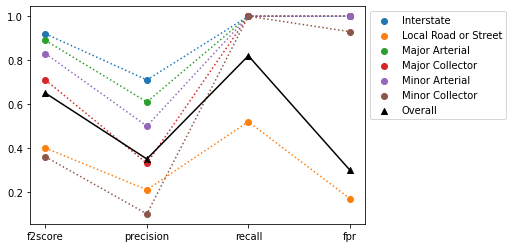

In [25]:
best_thres = model_results[1]
y_test_pred = RFmodel_fitted.predict_proba(X_test_OHtransformed)[:,1]
y_test_pred_adj = [1 if y>=best_thres else 0 for y in y_test_pred]
cfm_fc_df = cfm_fc(X_test, y_test, y_test_pred_adj)
cfm_fc_df

## XGBoost

In [26]:
from xgboost import XGBClassifier

Hyperparamater tuning range:
- max_depth in [3,4,5,6,7,8]
- eta: [0.1,0.3,0.5]
- subsample:[0.6,0.8,1]
- min_child_weight: [1,2,3,4,5]
- scale_pos_weight: [1,3,5,7,9]

In [27]:
# XGB model tuning enabled by AWS_EC2_BinaryUrban_XGB.py
with open(base_file_dir+'data/AWS Tuning results/BinaryUrban_XGB_search_results.pkl', 'rb') as f:
    BinaryUrban_XGB_search_results = pickle.load(f)

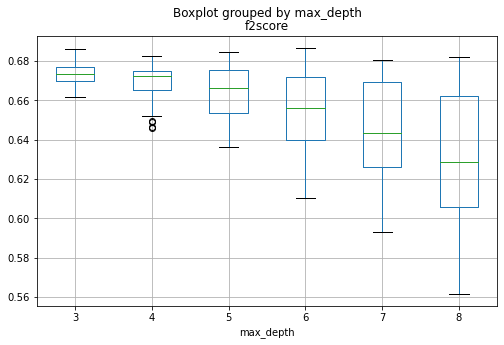

In [28]:
# An overview of the results of the model tuning executed on AWS EC2
BinaryUrban_XGB_search_results.boxplot(column=['f2score'],by='max_depth',figsize=(8,5))

From the boxplot, it can be concluded that the range of f2 score returned by the XGBoost algorithm varies with max_depth. The average performance of XGBoost is better than the other algorithms. 

In [29]:
BinaryUrban_XGB_search_results.sort_values(by=['f2score'],ascending=False).head(5)

max_depth  eta  subample  min_child_weight  scale_pos_weight  threshold  \
715          6  0.1       0.8                 4                 1       0.15   
77           3  0.3       0.6                 1                 5       0.41   
735          6  0.1       1.0                 3                 1       0.16   
461          5  0.1       0.6                 3                 3       0.34   
93           3  0.3       0.6                 4                 7       0.51   

     precision    recall   f1score   f2score       fpr    tn    fp   fn   tp  \
715   0.444093  0.795090  0.569882  0.686562  0.197711  4277  1054  217  842   
77    0.401546  0.833805  0.542050  0.686092  0.246858  4015  1316  176  883   
735   0.452420  0.785647  0.574189  0.684774  0.188895  4324  1007  227  832   
461   0.441470  0.794145  0.567476  0.684742  0.199587  4267  1064  218  841   
93    0.420744  0.812087  0.554302  0.684713  0.222097  4147  1184  199  860   

         time  
715  0.734447  
77   0.460356  
735  0.616264  
461  0.669130  
93   0.460876

max_depth= 6 eta= 0.1 subsample= 0.8 min_child_weight= 4.0 scale_pos_weight= 1.0
Time needed for training the model:  3.41 seconds
No Skill Model PR AUC: 0.230
Model PR AUC: 0.741
From Training data:
Best Threshold=0.153656, precision=0.462, recall=0.848, F2_Score=0.727


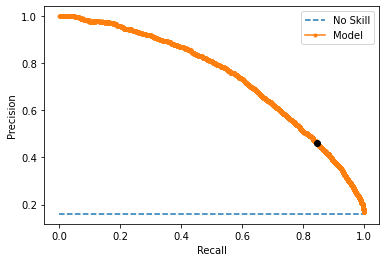

Results of testing data:
          pred_neg  pred_pos
true_neg      4315      1016
true_pos       226       833


In [30]:
sampling=None
Bestparam = zip(list(BinaryUrban_XGB_search_results.sort_values(by=['f2score'],ascending=False).head(1).columns), 
              BinaryUrban_XGB_search_results.sort_values(by=['f2score'],ascending=False).head(1).values.tolist()[0])
BestparamDict = dict(Bestparam)
print('max_depth=', int(BestparamDict['max_depth']), 'eta=', BestparamDict['eta'],'subsample=', BestparamDict['subample'],
     'min_child_weight=', BestparamDict['min_child_weight'],'scale_pos_weight=',BestparamDict['scale_pos_weight'])

XGBmodel=XGBClassifier(random_state = 42, n_jobs=-1,
                    max_depth=int(BestparamDict['max_depth']), eta=BestparamDict['eta'],subsample=BestparamDict['subample'],
                    min_child_weight=BestparamDict['min_child_weight'],scale_pos_weight=BestparamDict['scale_pos_weight'])
t0 = time.time()
XGBmodel_fitted=XGBmodel.fit(X_train_OHtransformed, y_train)
t1 = time.time()
print('Time needed for training the model: ',round(t1-t0,2),'seconds')
model_results= binary_summary_report (X_train_OHtransformed, y_train, X_test_OHtransformed, y_test, XGBmodel_fitted)

Interstate
          pred_neg  pred_pos
true_neg         0        31
true_pos         0        76
Local Road or Street
          pred_neg  pred_pos
true_neg      4068       470
true_pos       204       190
Major Arterial
          pred_neg  pred_pos
true_neg         8        90
true_pos         3       152
Major Collector
          pred_neg  pred_pos
true_neg       135       171
true_pos        12       137
Minor Arterial
          pred_neg  pred_pos
true_neg        50       232
true_pos         5       272
Minor Collector
          pred_neg  pred_pos
true_neg        54        22
true_pos         2         6
Overall
          pred_neg  pred_pos
true_neg      4315      1016
true_pos       226       833
F2score: 0.68 Precision: 0.45 Recall: 0.79 Fpr: 0.19


f2score precision recall   fpr
Interstate              0.92      0.71    1.0   1.0
Local Road or Street    0.42      0.29   0.48   0.1
Major Arterial          0.88      0.63   0.98  0.92
Major Collector         0.76      0.44   0.92  0.56
Minor Arterial          0.84      0.54   0.98  0.82
Minor Collector          0.5      0.21   0.75  0.29
Overall                 0.68      0.45   0.79  0.19

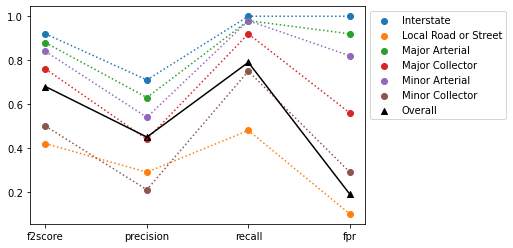

In [31]:
best_thres = model_results[1]
y_test_pred = XGBmodel_fitted.predict_proba(X_test_OHtransformed)[:,1]
y_test_pred_adj = [1 if y>=best_thres else 0 for y in y_test_pred]
cfm_fc_df = cfm_fc(X_test, y_test, y_test_pred_adj)
cfm_fc_df

## Conclusion

The highest f2 score obtained by each algorithm are listed in the following table. It can be observed that XGBoost outperforms the other models, having the highest f2 score with less time spent on the (full) test dataset. 

| Model | F2 | Precision | Recall | AUC | Time (seconds) |
| :-----------| :----------- |:----------- |:----------- |:----------- |:----------- |
| Logistic Regression | 0.66 | 0.39 | 0.8|0.591 |Approx. 3.0 |
| Support Vector Machine | 0.68 | 0.42 | 0.8 |0.662| Approx. 310.0|
| Random Forest | 0.65 | 0.35 |0.82|0.502 | Approx. 7.0 |
| eXtreme Gradient Boosting | 0.68| 0.45 |0.79 |0.741| Approx. 3.5|

*Time needed for training a model 

# Discovering the Best Model With the Selected Algorithm
<a id='discovering-the-best-model-with-the-selected-algorithm'></a>
[[back to top](#sections)]

Before the fine tuning process, which aims to discover the best model (the selected alogorithm with the corresponding hyperparameters), staff took a closer look at the results generated by the best XGBoost model found in the above section. 

**Findings**

It can be observed from the confusion matrix of the entire dataset and of each roadway functional class that:
- There are less than 20% of positive cases were classified as the negative cases by the model. For all the roadway functional classes, except for the Local Road or Street, the false negative rates are very low For Local Road or Street, the ratio is relativley high.
- There are about 19% of negative cases were classified to be positive cases by the model (false positive rate = 19%). Except for Local Road or Street and Minor Collector, the other roadway classes have more false positives than true negatives. This means that in the prediction results, there are many roads that are false alarmed.

**Analysis**

- For this project, the ability to be able to capture risky roads is more essential than to be able to identifying which roads are safe. Thus, the f2score is selected as the evaluation criteria, and the model is guided to capture as many risky roads as possible. 
- While the f2score evaluate true positive counts, false positive counts, and false negative counts, the number of true negative cases is not evaluated. The true negative counts would not be evaluated if the f2score is the only one criteria used for the model selection.
- The true negative counts is an essential element for calculating the false positive rate. Omitting the true negative counts in the evaluation process might lead to the problem of having a high false positive rate. 

**Decision**

Thus, while the model tuning process is based on the f2score, the final model would be selected basing on both f2score and false positive rate. To be more specific, first, the top 5 models that have the highest f2score would be selected as candidates. Then, the model with the lowest false positive rate among the top 5 candidates would be selected as the final model. 

## Model with highest f2score and lowest false positive rate

The following plots reveal the tradeoff between f2score and false positive rate, under different max_depth values.

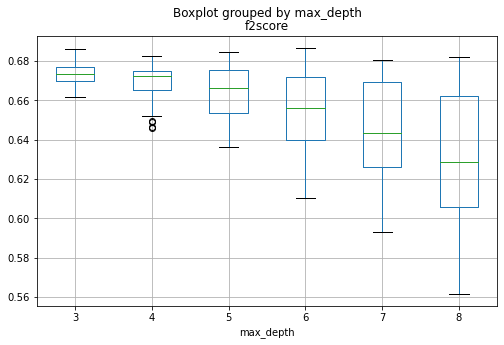

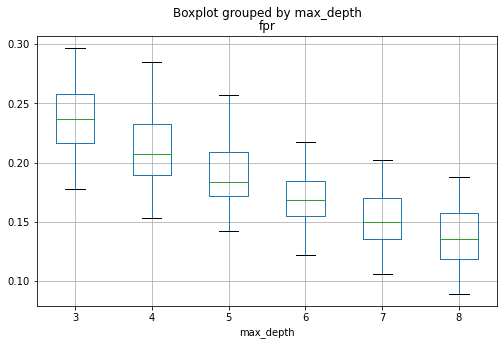

In [39]:
BinaryUrban_XGB_search_results.boxplot(column=['f2score'],by='max_depth',figsize=(8,5))
BinaryUrban_XGB_search_results.boxplot(column=['fpr'],by='max_depth',figsize=(8,5))

The following two tables reveal the difference in the model selection process before and after including the false positive rate.

In [40]:
Bestmodels = BinaryUrban_XGB_search_results.sort_values(by=['f2score'],ascending=False).head(5)
Bestmodels

max_depth  eta  subample  min_child_weight  scale_pos_weight  threshold  \
715          6  0.1       0.8                 4                 1       0.15   
77           3  0.3       0.6                 1                 5       0.41   
735          6  0.1       1.0                 3                 1       0.16   
461          5  0.1       0.6                 3                 3       0.34   
93           3  0.3       0.6                 4                 7       0.51   

     precision    recall   f1score   f2score       fpr    tn    fp   fn   tp  \
715   0.444093  0.795090  0.569882  0.686562  0.197711  4277  1054  217  842   
77    0.401546  0.833805  0.542050  0.686092  0.246858  4015  1316  176  883   
735   0.452420  0.785647  0.574189  0.684774  0.188895  4324  1007  227  832   
461   0.441470  0.794145  0.567476  0.684742  0.199587  4267  1064  218  841   
93    0.420744  0.812087  0.554302  0.684713  0.222097  4147  1184  199  860   

         time  
715  0.734447  
77   0.460356  
735  0.616264  
461  0.669130  
93   0.460876

In [41]:
Lowfprmodels = Bestmodels.sort_values(by=['fpr']).head(5)
Lowfprmodels

max_depth  eta  subample  min_child_weight  scale_pos_weight  threshold  \
735          6  0.1       1.0                 3                 1       0.16   
715          6  0.1       0.8                 4                 1       0.15   
461          5  0.1       0.6                 3                 3       0.34   
93           3  0.3       0.6                 4                 7       0.51   
77           3  0.3       0.6                 1                 5       0.41   

     precision    recall   f1score   f2score       fpr    tn    fp   fn   tp  \
735   0.452420  0.785647  0.574189  0.684774  0.188895  4324  1007  227  832   
715   0.444093  0.795090  0.569882  0.686562  0.197711  4277  1054  217  842   
461   0.441470  0.794145  0.567476  0.684742  0.199587  4267  1064  218  841   
93    0.420744  0.812087  0.554302  0.684713  0.222097  4147  1184  199  860   
77    0.401546  0.833805  0.542050  0.686092  0.246858  4015  1316  176  883   

         time  
735  0.616264  
715  0.734447  
461  0.669130  
93   0.460876  
77   0.460356

max_depth= 6 eta= 0.1 subsample= 1.0 min_child_weight= 3.0 scale_pos_weight= 1.0
Time needed for training the model:  1.88 seconds
No Skill Model PR AUC: 0.230
Model PR AUC: 0.739
From Training data:
Best Threshold=0.162082, precision=0.469, recall=0.838, F2_Score=0.724


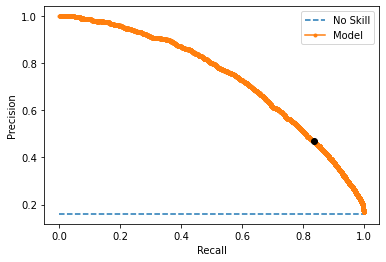

Results of testing data:
          pred_neg  pred_pos
true_neg      4334       997
true_pos       232       827


In [42]:
# model with high f2score and low false positive rate
from xgboost import XGBClassifier
Bestparam = zip(list(Lowfprmodels.head(1).columns), 
              Lowfprmodels.head(1).values.tolist()[0])
BestparamDict = dict(Bestparam)
print('max_depth=', int(BestparamDict['max_depth']), 'eta=', BestparamDict['eta'],'subsample=', BestparamDict['subample'],
     'min_child_weight=', BestparamDict['min_child_weight'],'scale_pos_weight=',BestparamDict['scale_pos_weight'])

sampling=None
XGBmodel=XGBClassifier(random_state = 42, n_jobs=-1,
                    max_depth=int(BestparamDict['max_depth']), eta=BestparamDict['eta'],subsample=BestparamDict['subample'],
                    min_child_weight=BestparamDict['min_child_weight'],scale_pos_weight=BestparamDict['scale_pos_weight'])
t0 = time.time()
XGBmodel_fitted=XGBmodel.fit(X_train_OHtransformed, y_train)
t1 = time.time()
print('Time needed for training the model: ',round(t1-t0,2),'seconds')
model_results= binary_summary_report (X_train_OHtransformed, y_train, X_test_OHtransformed, y_test, XGBmodel_fitted)

Interstate
          pred_neg  pred_pos
true_neg        13       137
true_pos         0       278
Local Road or Street
          pred_neg  pred_pos
true_neg     16523      1622
true_pos       612       971
Major Arterial
          pred_neg  pred_pos
true_neg        63       358
true_pos         0       591
Major Collector
          pred_neg  pred_pos
true_neg       574       712
true_pos        29       505
Minor Arterial
          pred_neg  pred_pos
true_neg       208       979
true_pos        13      1036
Minor Collector
          pred_neg  pred_pos
true_neg       206        74
true_pos        10        46
Overall
          pred_neg  pred_pos
true_neg     17587      3882
true_pos       664      3427
F2score: 0.72 Precision: 0.47 Recall: 0.84 Fpr: 0.18


f2score precision recall   fpr
Interstate              0.91      0.67    1.0  0.91
Local Road or Street    0.54      0.37   0.61  0.09
Major Arterial          0.89      0.62    1.0  0.85
Major Collector         0.75      0.41   0.95  0.55
Minor Arterial          0.83      0.51   0.99  0.82
Minor Collector         0.67      0.38   0.82  0.26
Overall                 0.72      0.47   0.84  0.18

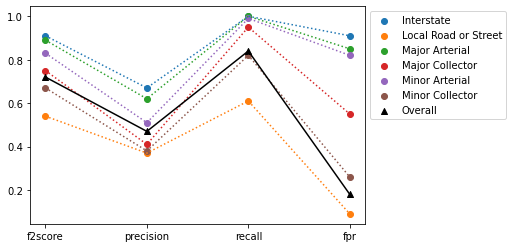

In [43]:
best_thres = model_results[1]
y_train_pred = XGBmodel_fitted.predict_proba(X_train_OHtransformed)[:,1]
y_train_pred_adj = [1 if y>=best_thres else 0 for y in y_train_pred]
# Confusion matrix
cfm_fc_df = cfm_fc(X_train, y_train, y_train_pred_adj)
cfm_fc_df

Interstate
          pred_neg  pred_pos
true_neg         3        28
true_pos         0        76
Local Road or Street
          pred_neg  pred_pos
true_neg      4092       446
true_pos       208       186
Major Arterial
          pred_neg  pred_pos
true_neg         9        89
true_pos         5       150
Major Collector
          pred_neg  pred_pos
true_neg       131       175
true_pos        12       137
Minor Arterial
          pred_neg  pred_pos
true_neg        47       235
true_pos         6       271
Minor Collector
          pred_neg  pred_pos
true_neg        52        24
true_pos         1         7
Overall
          pred_neg  pred_pos
true_neg      4334       997
true_pos       232       827
F2score: 0.68 Precision: 0.45 Recall: 0.78 Fpr: 0.19


f2score precision recall   fpr
Interstate              0.93      0.73    1.0   0.9
Local Road or Street    0.42      0.29   0.47   0.1
Major Arterial          0.87      0.63   0.97  0.91
Major Collector         0.75      0.44   0.92  0.57
Minor Arterial          0.84      0.54   0.98  0.83
Minor Collector         0.56      0.23   0.88  0.32
Overall                 0.68      0.45   0.78  0.19

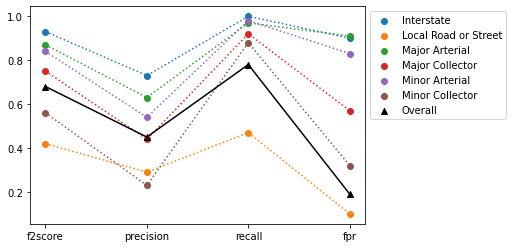

In [44]:
best_thres = model_results[1]
y_test_pred = XGBmodel_fitted.predict_proba(X_test_OHtransformed)[:,1]
y_test_pred_adj = [1 if y>=best_thres else 0 for y in y_test_pred]
# Confusion matrix
Candi2_ModelPerf = cfm_fc(X_test, y_test, y_test_pred_adj)
Candi2_ModelPerf

# Resampling
<a id='resampling'></a>
[[back to top](#sections)]

As mentioned in the rural model chapter, resampling would not be applied for this study for the following reasons:
- Invalidity: The result shows that resampling is of no use for performance improvement.
- Uncertainty: Resampling adds uncertainty to the model performance, the performance heavily relies on which data points are resampled. 
- Complexity: Resampling data adds complexity to the model training process. The resampling ratio should be redefined once the distribution of the training data is changed.

# Final model
<a id='final-model'></a>
[[back to top](#sections)]

In [60]:
Bestmodels = BinaryUrban_XGB_search_results.sort_values(by=['f2score'],ascending=False).head(5)
Lowfprmodels = Bestmodels.sort_values(by=['fpr']).head(1)
Lowfprmodels

max_depth  eta  subample  min_child_weight  scale_pos_weight  threshold  \
735          6  0.1       1.0                 3                 1       0.16   

     precision    recall   f1score   f2score       fpr    tn    fp   fn   tp  \
735    0.45242  0.785647  0.574189  0.684774  0.188895  4324  1007  227  832   

         time  
735  0.616264

6.0 0.1 1.0 3.0 1.0
Time needed for training one model: 1.9623005390167236 seconds
No Skill Model PR AUC: 0.223
Model PR AUC: 0.739
From Training data:
Best Threshold=0.162082, precision=0.469, recall=0.838, F2_Score=0.724


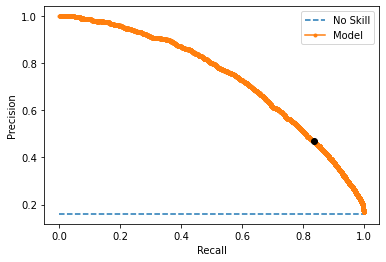

Results of testing data:
          pred_neg  pred_pos
true_neg      4334       997
true_pos       232       827


In [62]:
# model with high f2score and low false positive rate
from xgboost import XGBClassifier
Bestparam = zip(list(Lowfprmodels.head(1).columns), 
              Lowfprmodels.head(1).values.tolist()[0])
BestparamDict = dict(Bestparam)
print(BestparamDict['max_depth'], BestparamDict['eta'],BestparamDict['subample'],
    BestparamDict['min_child_weight'],BestparamDict['scale_pos_weight'])
sampling=None
XGBmodel=XGBClassifier(random_state = 42, n_jobs=-1,
                    max_depth=int(BestparamDict['max_depth']), eta=BestparamDict['eta'],subsample=BestparamDict['subample'],
                    min_child_weight=BestparamDict['min_child_weight'],scale_pos_weight=BestparamDict['scale_pos_weight'])
t0 = time.time()
XGBmodel_fitted=XGBmodel.fit(X_train_OHtransformed, y_train)
t1 = time.time()
print('Time needed for training one model:',t1-t0, 'seconds')
model_results= binary_summary_report (X_train_OHtransformed, y_train, X_test_OHtransformed, y_test, XGBmodel_fitted)

Interstate
          pred_neg  pred_pos
true_neg         3        28
true_pos         0        76
Local Road or Street
          pred_neg  pred_pos
true_neg      4092       446
true_pos       208       186
Major Arterial
          pred_neg  pred_pos
true_neg         9        89
true_pos         5       150
Major Collector
          pred_neg  pred_pos
true_neg       131       175
true_pos        12       137
Minor Arterial
          pred_neg  pred_pos
true_neg        47       235
true_pos         6       271
Minor Collector
          pred_neg  pred_pos
true_neg        52        24
true_pos         1         7
Overall
          pred_neg  pred_pos
true_neg      4334       997
true_pos       232       827
F2score: 0.68 Precision: 0.45 Recall: 0.78 Fpr: 0.19


f2score precision recall   fpr
Interstate              0.93      0.73    1.0   0.9
Local Road or Street    0.42      0.29   0.47   0.1
Major Arterial          0.87      0.63   0.97  0.91
Major Collector         0.75      0.44   0.92  0.57
Minor Arterial          0.84      0.54   0.98  0.83
Minor Collector         0.56      0.23   0.88  0.32
Overall                 0.68      0.45   0.78  0.19

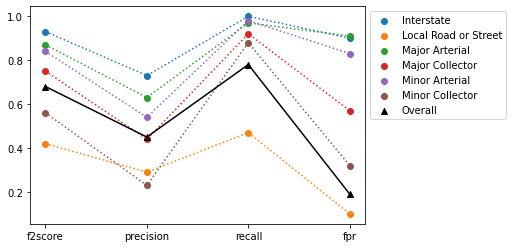

In [63]:
best_thres = model_results[1]
y_test_pred = XGBmodel_fitted.predict_proba(X_test_OHtransformed)[:,1]
y_test_pred_adj = [1 if y>=best_thres else 0 for y in y_test_pred]
# Confusion matrix
Candi2_ModelPerf = cfm_fc(X_test, y_test, y_test_pred_adj)
Candi2_ModelPerf

In [64]:
# Model info (saved later)
model_str = 'XGB'
timestr=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = model_str+str(timestr)
segment_intersection='segment'
model_geography='urban'
model_type='binary'

sampling_str='None'
other_pre_processing='None'

auc = model_results[0]
best_thres = model_results[1]
f2 = model_results[2]
n_variables=len(X_train.columns)
variables=X_train.columns
stage=model_str+'hyper-para tuning'
hyper_para=BestparamDict

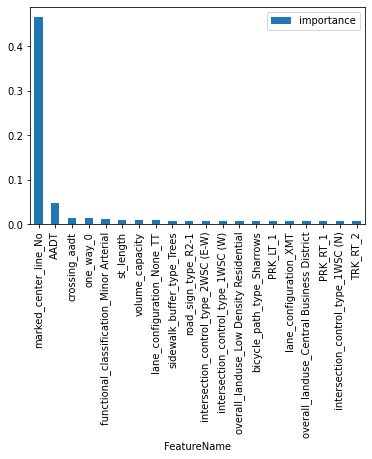

In [65]:
# feature importance
FeatureImportance = pd.DataFrame()
FeatureImportance['FeatureName'] = OHfname
FeatureImportance['importance'] = XGBmodel_fitted.feature_importances_
FeatureImportance['ABSimportance'] = abs(XGBmodel_fitted.feature_importances_)
FeatureImportance = FeatureImportance.sort_values(by='ABSimportance',ascending=False)

# Save top 10 importance features
top_features=FeatureImportance.iloc[0:20,:].FeatureName.values
# Plot top 20 importance features
FeatureImportance.iloc[0:20,:].plot.bar(x='FeatureName', y='importance', rot=90)

In [66]:
map_train = '2014-2017'
map_test = 2018

In [67]:
# # Save model in pkl
# model_str = 'XGB'
# timestr=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# model_name = model_str+str(timestr)
# segment_intersection='segment'
# model_geography='urban'
# model_type='binary'
# print(model_name)
# path=base_file_dir+'models/'+segment_intersection+'/'+model_geography+'/'+model_type+'/'
# os.makedirs(path, exist_ok=True)
# with open(path+model_name+'.pkl', 'wb') as f:
#     pickle.dump(XGBmodel_fitted, f)    

XGB20210517-001215


<mark> model saved as **urban_binary_XGB_trainedw2014_2017_best_thres0.162** </mark>

## Mapping

In [68]:
with open(base_file_dir+'data/interim/roadway/data_source/streets.pkl', 'rb') as f:
    streets = pickle.load(f)
# Project PCD roadway segments to epsg:3435
geo_SegmentID = geo_segmentid(streets)

# Plotting
with open(base_file_dir+'/data/processed/df_urban.pkl', 'rb') as f:
    df_urban = pickle.load(f)
df_urban_map=df_urban[['segment_id','geometry','Year','Crashes','in_urbanized_area']]
X_test_observed_map=df_urban_map.loc[X_test.index]
X_train_observed_map=df_urban_map.loc[X_train.index]

### Training data

In [69]:
map_name = model_type+'_'+'XGB'+'_'+map_train+'_predicted'+'_'+timestr
print(map_name)

binary_XGB_2014-2017_predicted_20210517-001215


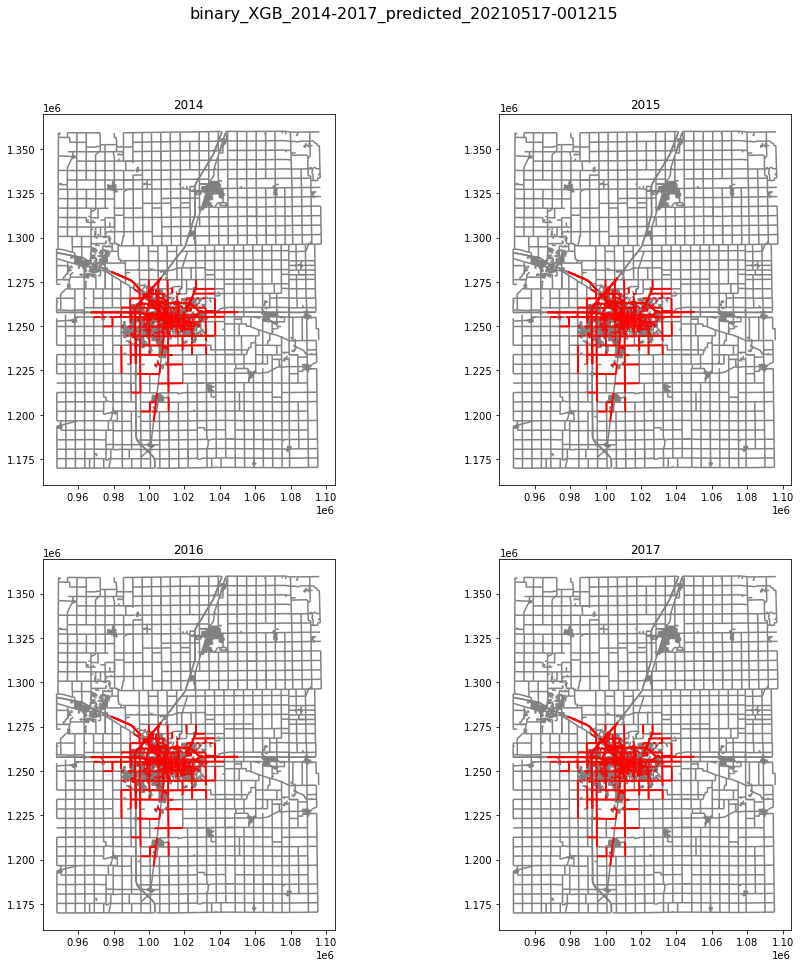

In [70]:
# Prepare plotting data
y_pred = XGBmodel_fitted.predict_proba(X_train_OHtransformed)[:,1]
y_pred_adj = [1 if y>=best_thres else 0 for y in y_pred]
prediction_result = y_pred_adj
# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15,15))
axes = axes.flatten()
prediction_binary_maps (axes[0],geo_SegmentID, X_train_observed_map, prediction_result, 2014, 'segment','urban','XGB',map_name)
prediction_binary_maps (axes[1],geo_SegmentID, X_train_observed_map, prediction_result, 2015, 'segment','urban','XGB',map_name)
prediction_binary_maps (axes[2],geo_SegmentID, X_train_observed_map, prediction_result, 2016, 'segment','urban','XGB',map_name)
prediction_binary_maps (axes[3],geo_SegmentID, X_train_observed_map, prediction_result, 2017, 'segment','urban','XGB',map_name)
# Title and save figure
fig.suptitle(map_name, fontsize=16)
fig.savefig('../../reports/figures/model_results/segment_intersection/trainingdata/'+ map_name+'.png')

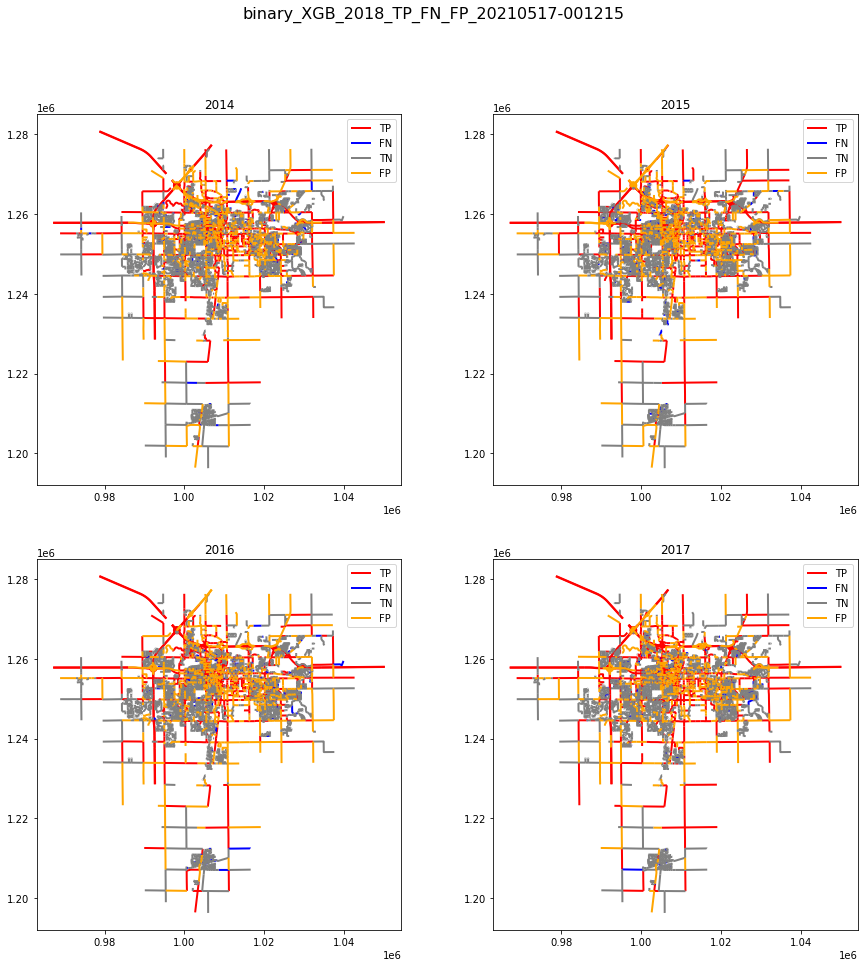

In [81]:
# Prepare plotting data

y_pred = XGBmodel_fitted.predict_proba(X_train_OHtransformed)[:,1]
y_pred_adj = [1 if y>=best_thres else 0 for y in y_pred]
prediction_result = y_pred_adj
# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15,15))
axes = axes.flatten()
prediction_binary_diff_maps (axes[0],X_train_observed_map, y_train, prediction_result, 2014, segment_intersection, model_name, map_name)
prediction_binary_diff_maps (axes[1],X_train_observed_map, y_train, prediction_result, 2015, segment_intersection, model_name, map_name)
prediction_binary_diff_maps (axes[2],X_train_observed_map, y_train, prediction_result, 2016, segment_intersection, model_name, map_name)
prediction_binary_diff_maps (axes[3],X_train_observed_map, y_train, prediction_result, 2017, segment_intersection, model_name, map_name)
# Title and save figure
fig.suptitle(map_name, fontsize=16)
fig.savefig('../../reports/figures/model_results/segment_intersection/trainingdata/'+ map_name+'.png')
# red: TP, blue: FN, orange: FP

### Testing data

In [73]:
map_name = model_type+'_'+'XGB'+'_'+str(map_test)+'_predicted'+'_'+timestr
print(map_name)

binary_XGB_2018_predicted_20210517-001215


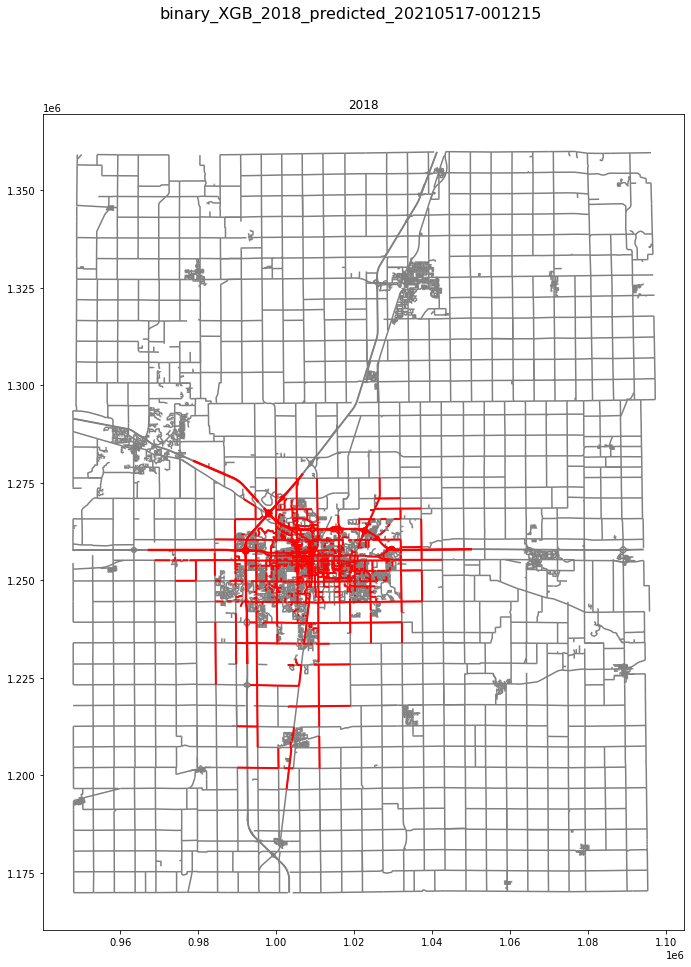

In [75]:
# Prepare plotting data

y_test_pred = XGBmodel_fitted.predict_proba(X_test_OHtransformed)[:,1]
y_test_pred_adj = [1 if y>=best_thres else 0 for y in y_test_pred]
# Plotting
fig, ax = plt.subplots(figsize=(15,15))
prediction_binary_maps (ax,geo_SegmentID, X_test_observed_map, y_test_pred_adj, 2018, 'segment','urban','XGB',map_name)
# Title and save figure
fig.suptitle(map_name, fontsize=16)
fig.savefig('../../reports/figures/model_results/segment_intersection/testingdata/'+map_name+'.png')

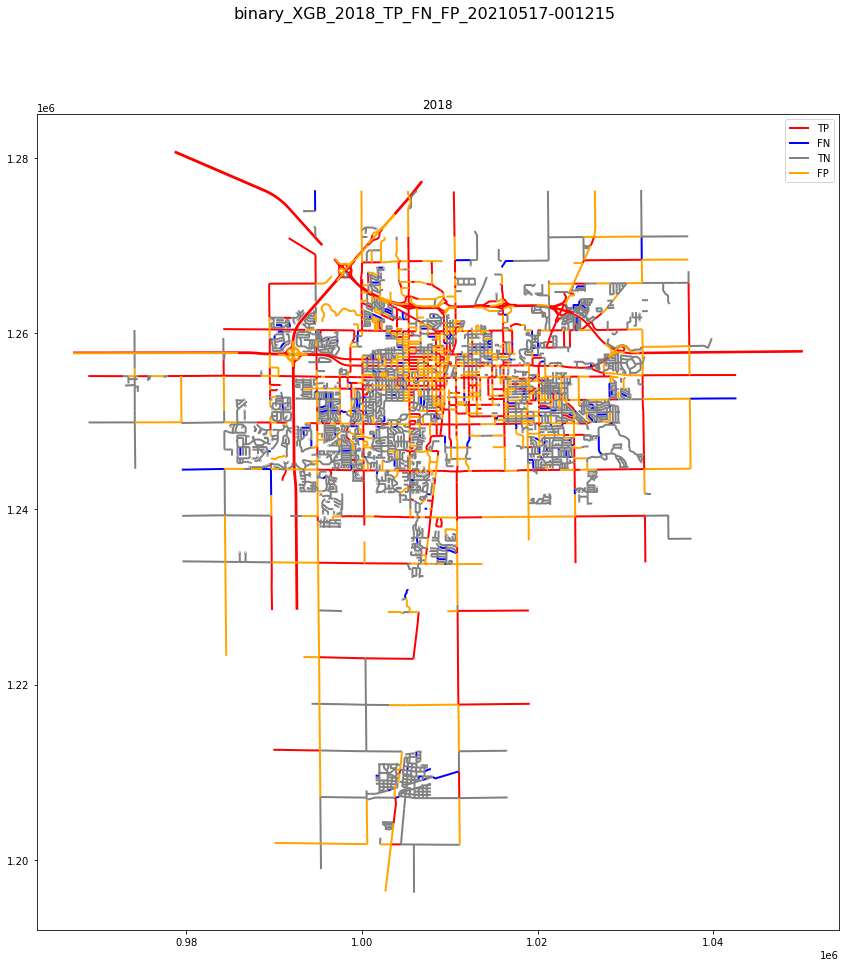

In [82]:
fig, ax = plt.subplots(figsize=(15,15))
map_name = model_type+'_'+'XGB'+'_'+str(map_test)+'_TP_FN_FP'+'_'+timestr
prediction_binary_diff_maps (ax,X_test_observed_map, y_test, y_test_pred_adj, 2018, segment_intersection, model_name, map_name)
# red: TP, blue: FN, orange: FP